In [1]:
%load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual, HBox, VBox, Output
from ipywidgets import IntSlider, IntText, FloatSlider, FloatText, IntRangeSlider, FloatRangeSlider
# import ipywidgets as widgets

from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6


import sys, os


# import mplfinance as mpf
%matplotlib inline

# plt.rcParams['lines.linewidth'] = 0.5 



<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.7.6, build 905165378
Copyright (C) 2014-2023 Monash University, NICTA, Data61


In [2]:
def calc_repayments(price = 375000, years=20, deposit_sum=None, deposit_pct=0.2, interest_rate=0.06, monthly_overpayment=0., lump_sum_payments={} ):
  deposit = deposit_sum
  if deposit is None:
    deposit = price * deposit_pct

  principal = price - deposit
  monthly_rate = interest_rate / 12.  # Monthly interest rate
  num_payments = years * 12  # Total number of payments (20 years * 12 months)
  monthly_payment = (principal * monthly_rate) / (1 - (1 + monthly_rate) ** -num_payments)
  # print('interest_rate', interest_rate)
  # print('principal', principal)
  # print('monthly_rate', monthly_rate)
  # print('num_payments', num_payments)
  # print('deposit', deposit)
  # print('monthly_payment', monthly_payment)
  # print('principal * monthly_rate', principal * monthly_rate)
  # print('(1 - (1 + monthly_rate) ** -num_payments)', (1 - (1 + monthly_rate) ** -num_payments))

  remaining_balance = principal
  amortization_table = []

  for month in range(1, num_payments + 1):
      interest_payment = remaining_balance * monthly_rate
      capital_payment = monthly_payment - interest_payment
      remaining_balance = remaining_balance - (capital_payment + monthly_overpayment)

      for lump_sum in lump_sum_payments:
          if month == lump_sum['month']:
              remaining_balance -= lump_sum['amount']

      amortization_table.append({
          'Month': month,
          'Monthly_Payment': monthly_payment + monthly_overpayment,
          'Interest_Payment': interest_payment,
          'Capital_Payment': capital_payment,
          'Lump_Sum': sum(lump_sum['amount'] for lump_sum in lump_sum_payments if month >= lump_sum['month']),
          'Remaining_Balance': remaining_balance
      })

  df = pd.DataFrame(amortization_table)
  df = df.assign(dtime=pd.date_range(datetime.today().date(), periods=df.shape[0], freq="M")
  ).assign(month=range(df.shape[0])).set_index('month')#.round(2)
  # df.set_index(pd.PeriodIndex(df.Month, freq='M'))
  df['int2princ'] = df['Interest_Payment'] / df['Capital_Payment']
  df['Capital_PLUS_Interest'] = df['Interest_Payment'] + df['Capital_Payment']
  df['cum_interest'] = df.Interest_Payment.cumsum()
  # df = df.round(2)
  df = df[df.Remaining_Balance > 0].round(2)
  return df.round(2)




In [55]:


lump_sum_payments = [
    # {'month': 1, 'amount': 50000},
    {'month': 18, 'amount': 150000},
    # {'month': 24, 'amount': 11000},
    # {'month': 36, 'amount': 12000},
    # {'month': 18, 'amount': 20000}
]

df = pd.concat([
    calc_repayments(price=350000, years=20, deposit_sum=100000, interest_rate=0.056, monthly_overpayment=0, lump_sum_payments=lump_sum_payments),
    calc_repayments(price=350000, years=25, deposit_sum=100000, interest_rate=0.056, monthly_overpayment=2000, lump_sum_payments=lump_sum_payments)
], axis=1, join='outer', keys=['No_Overpayment', 'Overpayment_2000'])
df
# fig = plt.figure(figsize=(15,4))

# ax1,ax2 = fig.subplots(1,2)
# df[['Monthly_Payment', 'Interest_Payment']].plot(ax=ax1)
# ax1tx = ax1.twinx()
# # df.iloc[:, -1].plot(ax=ax2, figsize=(15,5), c='gray', linestyle='dashed')
# ax1.axhline()
# df.iloc[:, -2].plot(ax=ax1tx, c='gray', linestyle='dashed', legend=True)
# # df.iloc[:, 1:2].plot(ax=ax2, colors=['b','r'], legend=True)
# df['Capital_PLUS_Interest'].plot(ax=ax2, c='b', lw=2, legend=True)
# df['Interest_Payment'].plot(ax=ax2, c='r', lw=2, legend=True)
# ax2tx = ax2.twinx()
# df[['Remaining_Balance']].plot(ax=ax2tx, c='gray', linestyle='dashed', legend=True)
# fig.tight_layout(pad=2)
# ax1.grid()
# ax2.grid()
# plt.grid()

No_Overpayment                                                   \
               Month Monthly_Payment Interest_Payment Capital_Payment   
month                                                                   
0                  1          1932.9          1500.00          432.90   
1                  2          1932.9          1497.84          435.07   
2                  3          1932.9          1495.66          437.24   
3                  4          1932.9          1493.47          439.43   
4                  5          1932.9          1491.28          441.63   
...              ...             ...              ...             ...   
81                82          1932.9            47.61         1885.29   
82                83          1932.9            38.19         1894.72   
83                84          1932.9            28.71         1904.19   
84                85          1932.9            19.19         1913.71   
85                86          1932.9             9.62         1923.28   

                                                                             \
      Lump_Sum Remaining_Balance      dtime int2princ Capital_PLUS_Interest   
month                                                                         
0            0         299567.10 2023-07-31      3.46                1932.9   
1            0         299132.03 2023-08-31      3.44                1932.9   
2            0         298694.78 2023-09-30      3.42                1932.9   
3            0         298255.35 2023-10-31      3.40                1932.9   
4            0         297813.73 2023-11-30      3.38                1932.9   
...        ...               ...        ...       ...                   ...   
81      181000           7637.29 2030-04-30      0.03                1932.9   
82      181000           5742.57 2030-05-31      0.02                1932.9   
83      181000           3838.38 2030-06-30      0.02                1932.9   
84      181000           1924.67 2030-07-31      0.01                1932.9   
85      181000              1.39 2030-08-31      0.01                1932.9   

                   Overpayment_2000                                   \
      cum_interest            Month Monthly_Payment Interest_Payment   
month                                                                  
0          1500.00              1.0          3932.9          1500.00   
1          2997.84              2.0          3932.9          1487.84   
2          4493.50              3.0          3932.9          1475.61   
3          5986.97              4.0          3932.9          1463.32   
4          7478.25              5.0          3932.9          1450.98   
...            ...              ...             ...              ...   
81        47135.44              NaN             NaN              NaN   
82        47173.62              NaN             NaN              NaN   
83        47202.33              NaN             NaN              NaN   
84        47221.53              NaN             NaN              NaN   
85        47231.15              NaN             NaN              NaN   

                                                                       \
      Capital_Payment Lump_Sum Remaining_Balance      dtime int2princ   
month                                                                   
0              432.90      0.0         297567.10 2023-07-31      3.46   
1              445.07      0.0         295122.03 2023-08-31      3.34   
2              457.29      0.0         292664.73 2023-09-30      3.23   
3              469.58      0.0         290195.15 2023-10-31      3.12   
4              481.93      0.0         287713.22 2023-11-30      3.01   
...               ...      ...               ...        ...       ...   
81                NaN      NaN               NaN        NaT       NaN   
82                NaN      NaN               NaN        NaT       NaN   
83                NaN      NaN               NaN        NaT     

In [56]:
df.loc(axis=1)[:,['Interest_Payment', 'Monthly_Payment']]

,No_Overpayment,Overpayment_2000,No_Overpayment,Overpayment_2000
,Interest_Payment,Interest_Payment,Monthly_Payment,Monthly_Payment
month,,,,
0,1500.00,1500.00,1932.9,3932.9
1,1497.84,1487.84,1932.9,3932.9
2,1495.66,1475.61,1932.9,3932.9
3,1493.47,1463.32,1932.9,3932.9
4,1491.28,1450.98,1932.9,3932.9
...,...,...,...,...
81,47.61,NaN,1932.9,NaN
82,38.19,NaN,1932.9,NaN


<Axes: xlabel='month'>

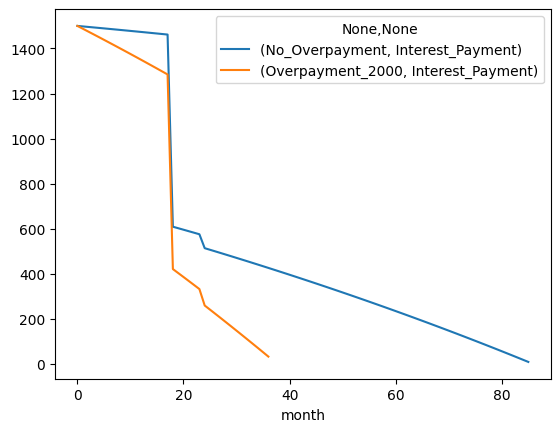

In [59]:
df.loc(axis=1)[:,['Interest_Payment']].plot()

<Axes: xlabel='month'>

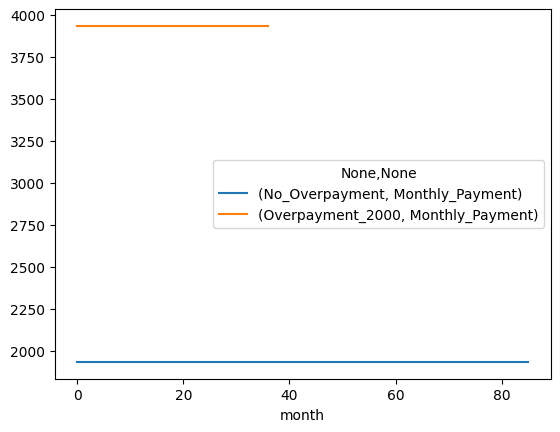

In [58]:
df.loc(axis=1)[:,['Monthly_Payment']].plot()

In [60]:
lump_sum_payments = [
    # {'month': 1, 'amount': 50000},
    {'month': 18, 'amount': 170000},
    {'month': 24, 'amount': 11000},
    # {'month': 36, 'amount': 12000},
    # {'month': 18, 'amount': 20000}
]

df = pd.concat([
    calc_repayments(price=375000, years=15, deposit_pct=0.2, interest_rate=0.06, monthly_overpayment=0, lump_sum_payments=lump_sum_payments),
    calc_repayments(price=375000, years=20, deposit_pct=0.2, interest_rate=0.06, monthly_overpayment=0, lump_sum_payments=lump_sum_payments),
    calc_repayments(price=375000, years=25, deposit_pct=0.2, interest_rate=0.06, monthly_overpayment=0, lump_sum_payments=lump_sum_payments),
], axis=1, join='outer', keys=['years_15', 'year_20', 'years_25'])
df

years_15                                                            \
         Month Monthly_Payment Interest_Payment Capital_Payment Lump_Sum   
month                                                                      
0          1.0         2531.57          1500.00         1031.57      0.0   
1          2.0         2531.57          1494.84         1036.73      0.0   
2          3.0         2531.57          1489.66         1041.91      0.0   
3          4.0         2531.57          1484.45         1047.12      0.0   
4          5.0         2531.57          1479.21         1052.36      0.0   
...        ...             ...              ...             ...      ...   
81         NaN             NaN              NaN             NaN      NaN   
82         NaN             NaN              NaN             NaN      NaN   
83         NaN             NaN              NaN             NaN      NaN   
84         NaN             NaN              NaN             NaN      NaN   
85         NaN             NaN              NaN             NaN      NaN   

                                                                    \
      Remaining_Balance      dtime int2princ Capital_PLUS_Interest   
month                                                                
0             298968.43 2023-07-31      1.45               2531.57   
1             297931.70 2023-08-31      1.44               2531.57   
2             296889.79 2023-09-30      1.43               2531.57   
3             295842.67 2023-10-31      1.42               2531.57   
4             294790.31 2023-11-30      1.41               2531.57   
...                 ...        ...       ...                   ...   
81                  NaN        NaT       NaN                   NaN   
82                  NaN        NaT       NaN                   NaN   
83                  NaN        NaT       NaN                   NaN   
84                  NaN        NaT       NaN                   NaN   
85                  NaN        NaT       NaN                   NaN   

                    ... years_25                                   \
      cum_interest  ...    Month Monthly_Payment Interest_Payment   
month               ...                                             
0          1500.00  ...        1          1932.9          1500.00   
1          2994.84  ...        2          1932.9          1497.84   
2          4484.50  ...        3          1932.9          1495.66   
3          5968.95  ...        4          1932.9          1493.47   
4          7448.16  ...        5          1932.9          1491.28   
...            ...  ...      ...             ...              ...   
81             NaN  ...       82          1932.9            47.61   
82             NaN  ...       83          1932.9            38.19   
83             NaN  ...       84          1932.9            28.71   
84             NaN  ...       85          1932.9            19.19   
85             NaN  ...       86          1932.9             9.62   

                                                                       \
      Capital_Payment Lump_Sum Remaining_Balance      dtime int2princ   
month                                                                   
0              432.90        0         299567.10 2023-07-31      3.46   
1              435.07        0         299132.03 2023-08-31      3.44   
2              437.24        0         298694.78 2023-09-30      3.42   
3              439.43        0         298255.35 2023-10-31      3.40   
4              441.63        0         297813.73 2023-11-30      3.38   
...               ...      ...               ...        ...       ...   
81            1885.29   181000           7637.29 2030-04-30      0.03   
82            1894.72   181000           5742.57 2030-05-31      0.02   
83            1904.19   181000           3838.38 2030-06-30      0.02   
84            1913.71   181000           1924.67 2030-07-31      0.01   
85            1923.28   181000              

In [65]:
df.loc(axis=1)[:,['Interest_Payment', 'Monthly_Payment']].fillna(0).cumsum()

,years_15,year_20,years_25,years_15,year_20,years_25
,Interest_Payment,Interest_Payment,Interest_Payment,Monthly_Payment,Monthly_Payment,Monthly_Payment
month,,,,,,
0,1500.00,1500.00,1500.00,2531.57,2149.29,1932.9
1,2994.84,2996.75,2997.84,5063.14,4298.58,3865.8
2,4484.50,4490.24,4493.50,7594.71,6447.87,5798.7
3,5968.95,5980.45,5986.97,10126.28,8597.16,7731.6
4,7448.16,7467.37,7478.25,12657.85,10746.45,9664.5
...,...,...,...,...,...,...
81,38182.45,43203.77,47135.44,156957.34,161196.75,158497.8
82,38182.45,43203.77,47173.63,156957.34,161196.75,160430.7
